# Deutsch-Jozsa Algorithm to generalize Deutsch's Algorithm

## Problem Statement  
Given a function  
$$
f: \{0, 1\}^n \rightarrow \{0, 1\}
$$  
determine whether \( f \) is **constant** (same output for all inputs) or **balanced** (outputs 0 for half of inputs and 1 for the other half) **using the fewest number of queries**.

Classically, this may require multiple queries. **Deutsch’s algorithm** uses **superposition and interference** to solve it with **a single query**.

---



In [38]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, Aer
from qiskit.visualization import plot_histogram

Let's begin by choosing some function to test on $f(x) = x \mod 2$.

Reciting the general definition of an oracle transformation $U_f$ that computes some function $f(n)$:

$$ U_f |x\rangle |y\rangle = |x\rangle |y \oplus f(x)\rangle $$

where $|x\rangle$ is the input register and $|y\rangle$ is the output register.


In our case: $$ U_f |x\rangle |y\rangle = |x\rangle |y \oplus (x \mod 2)\rangle = |x\rangle |y \oplus x_0)\rangle $$

where $x_0$ is the least significant bit of $x$.
This behavior is equivalent to a **CNOT gate** where $ \ket{x_0} $ is the control qubit and $ \ket{y} $ is the target qubit.  
In other words:

$$
y = 1 \iff q_0 = 1
$$
because:
$$
(x_n \ldots x_1 1) \bmod 2 = 1
$$
else:
$$
y = 0
$$

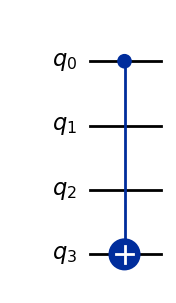

In [39]:
# Let f be some function
# Let's take f(x) = x mod 2
def f(x):
    return x % 2

# Let's begin by defining our oracle
def create_oracle(n, f):
    oracle = QuantumCircuit(n + 1)
    oracle.cx(0, n)

    return oracle

# Let n = 10
oracle = create_oracle(3, f)

oracle.draw('mpl')

Now we're ready to build our quantum circuit for the Deutsch-Josza algorithm.

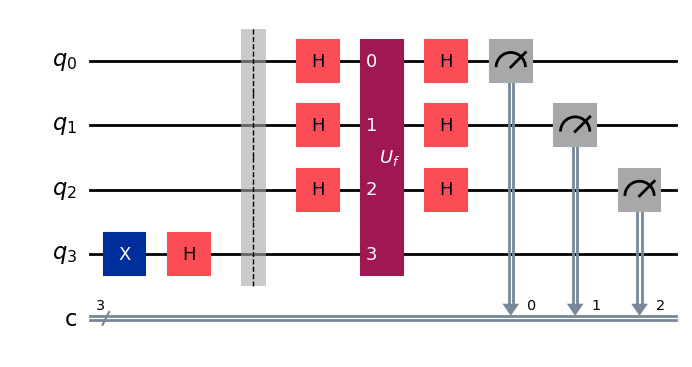

In [40]:
def create_deutsch_jozsa_circuit(n, f):
    qc = QuantumCircuit(n + 1, n)

    # Prepare $\ket{y}$ to be $\ket{-}$ for phase kickback
    qc.x(n)
    qc.h(n)

    # Begin the main circuit
    qc.barrier()

    # Set all qubits in super position
    for i in range(n):
        qc.h(i)
    
    oracle = create_oracle(n, f)
    Uf = oracle.to_gate()
    Uf.label = "$U_f$"

    # Step 2: apply oracle
    qc.compose(Uf, inplace=True)

    # Again, apply Hadamard to all $n$ qubits
    for i in range(n):
        qc.h(i)
        qc.measure(i, i)

    return qc  # make sure to return the circuit


qc = create_deutsch_jozsa_circuit(3, 0)
qc.draw('mpl')

Now, the fun part :) Let's simulate with Qiskit AER!!


In [41]:
# --- Simulation ---
simulator = AerSimulator()

# Need to use transpile() here to simplify my oracle circuit $U_f$
qct = transpile(qc, simulator)
# print(qct)

result = Aer.get_backend('statevector_simulator').run(qct, shots=1).result()
counts = result.get_counts(qct)
print("Counts:", counts)

if '000' in counts:
    print("The function is constant.")
else:
    print("The function is balanced.")

Counts: {'001': 1}
The function is balanced.
